In [1]:
ENV["COLUMNS"] = 200
using Distributions
using Optim: optimize, Brent
using Turing
using StatsPlots
default(fmt=:png, titlefontsize=12)

## 二項分布モデルの場合

### 無情報事前分布の場合

k = 6
n = 20
α = 0.05
prior = Beta{Float64}(α=1.0, β=1.0)

pointest_score = 0.3
pointest_bayes = 0.3
ci_score = [0.145, 0.519]
ci_bayes = [0.136, 0.509]



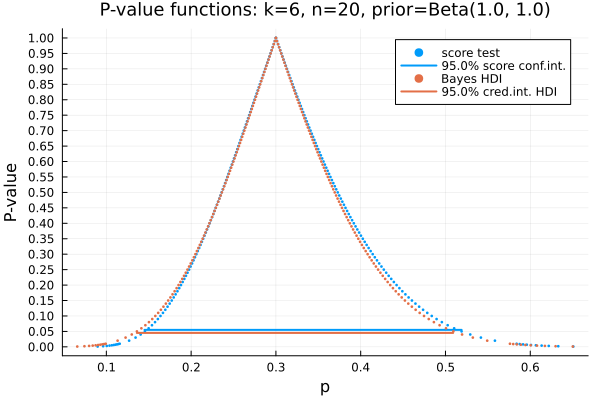

In [2]:
function confint_score(k, n, α=0.05)
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

sigdigits::Int = 3
r(x) = round(x; sigdigits=sigdigits)

function highest_density_interval(dist, α=0.05)
    f(p) = quantile(dist, min(1, p+(1-α))) - quantile(dist, p)
    o = optimize(f, 0, α, Brent())
    p = o.minimizer
    [quantile(dist, p), quantile(dist, min(1, p+(1-α)))]
end

function credint_hdi(k, n, α=0.05; prior=Beta(1, 1))
    κ, λ = params(prior)
    posterior = Beta(κ+k, λ+n-k)
    m = mode(posterior)
    α ≈ 1 && return [m, m]
    highest_density_interval(posterior, α)
end

function plot_ci(; k=7, n=24, α=0.05, prior=Beta(1, 1))
    κ, λ = params(prior)
    posterior = Beta(κ+k, λ+n-k)
    @show k n α prior
    println()
    pointest_score = k/n |> r
    pointest_bayes = mode(posterior) |> r
    @show pointest_score pointest_bayes
    ci_score = confint_score(k, n, α) .|> r
    ci_bayes = credint_hdi(k, n, α; prior) .|> r
    @show ci_score ci_bayes
    println()
    
    αs = [0.001:0.001:0.009; 0.01:0.01:1]
    plot(title="P-value functions: k=$k, n=$n, prior=Beta$(params(prior))")
    scatter!(vcat(confint_score.(k, n, αs)...), repeat(αs; inner=2); label="score test", ms=1.5, msc=:auto, c=1)
    plot!(ci_score, fill(1.1α, 2); label="$(100(1-α))% score conf.int.", c=1, lw=2)
    scatter!(vcat(credint_hdi.(k, n, αs; prior)...), repeat(αs; inner=2); label="Bayes HDI", ms=1.5, msc=:auto, c=2)
    plot!(ci_bayes, fill(0.9α, 2); label="$(100(1-α))% cred.int. HDI", c=2, lw=2)
    plot!(xguide="p", yguide="P-value")
    plot!(ytick=0:0.05:1)
end

plot_ci(; k=6, n=20)

k = 24
n = 80
α = 0.05
prior = Beta{Float64}(α=1.0, β=1.0)

pointest_score = 0.3
pointest_bayes = 0.3
ci_score = [0.211, 0.408]
ci_bayes = [0.208, 0.405]



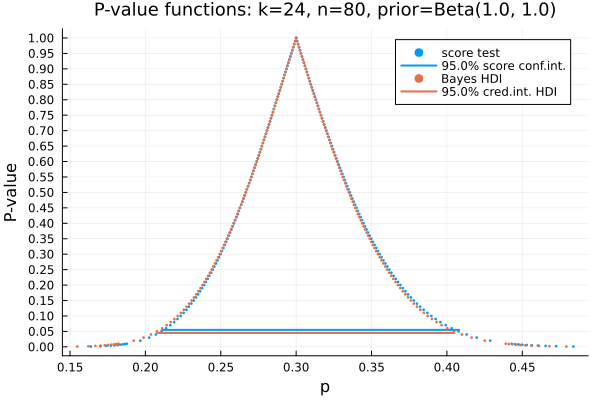

In [3]:
plot_ci(; k=24, n=80)

k = 96
n = 320
α = 0.05
prior = Beta{Float64}(α=1.0, β=1.0)

pointest_score = 0.3
pointest_bayes = 0.3
ci_score = [0.252, 0.352]
ci_bayes = [0.252, 0.352]



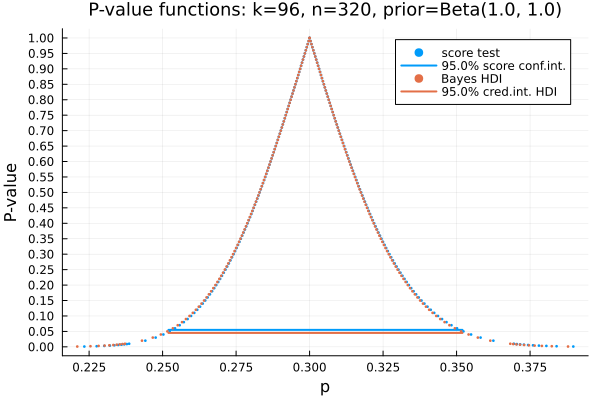

In [4]:
plot_ci(; k=96, n=320)

## 偏りのある事前分布の場合

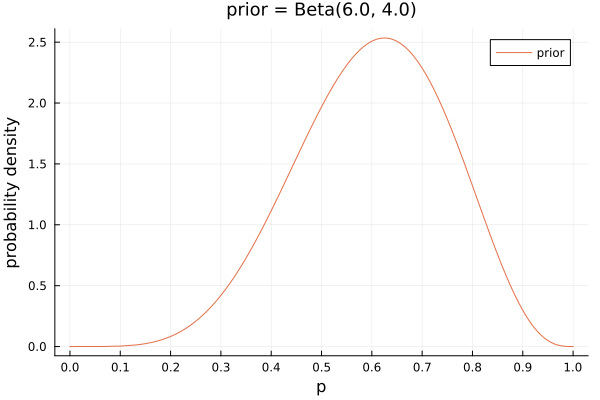

In [5]:
prior = Beta(6, 4)
plot(prior; label="prior", title="prior = Beta$(params(prior))", c=2)
plot!(xguide="p", yguide="probability density")
plot!(xtick=0:0.1:1)

k = 6
n = 20
α = 0.05
prior = Beta{Float64}(α=6.0, β=4.0)

pointest_score = 0.3
pointest_bayes = 0.393
ci_score = [0.145, 0.519]
ci_bayes = [0.231, 0.573]



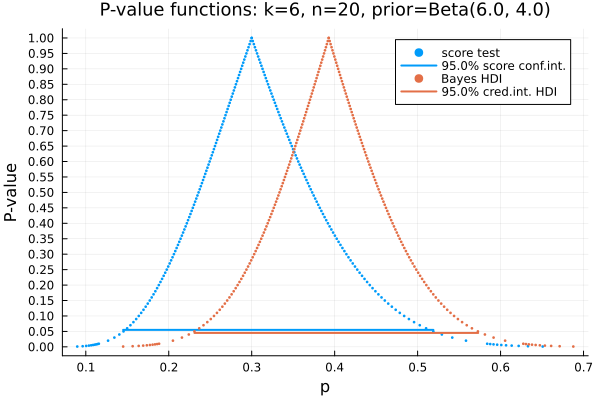

In [6]:
plot_ci(; k=6, n=20, prior)

k = 24
n = 80
α = 0.05
prior = Beta{Float64}(α=6.0, β=4.0)

pointest_score = 0.3
pointest_bayes = 0.33
ci_score = [0.211, 0.408]
ci_bayes = [0.238, 0.431]



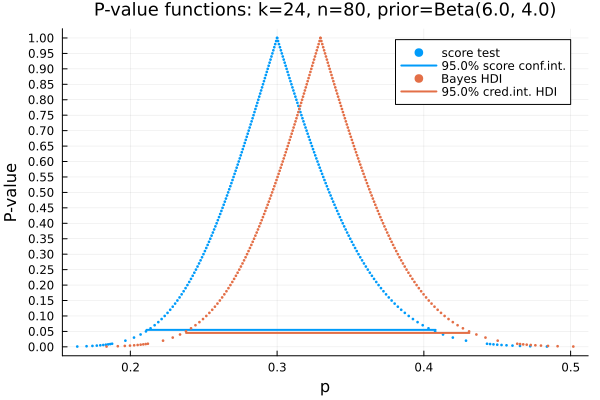

In [7]:
plot_ci(; k=24, n=80, prior)

k = 96
n = 320
α = 0.05
prior = Beta{Float64}(α=3.0, β=2.0)

pointest_score = 0.3
pointest_bayes = 0.303
ci_score = [0.252, 0.352]
ci_bayes = [0.255, 0.355]



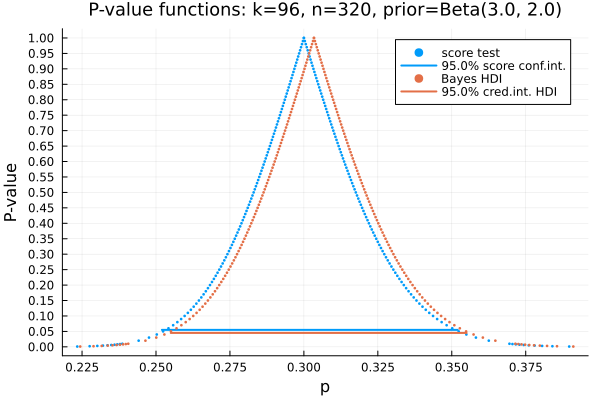

In [8]:
plot_ci(; k=96, n=320, prior=Beta(3, 2))

## 正規分布モデルの場合

In [9]:
r1(x) = round(x; digits=1)

function confintmean(n, x̄, s², α=0.05)
    c = cquantile(Normal(), α/2)
    sehat = √(s²/n)
    [x̄ - c*sehat, x̄ + c*sehat]
end

function confintmean(X, α=0.05)
    confintmean(length(X), mean(X), var(X), α)
end

@model function model_normal(X; prior_μ=Flat(), prior_logσ=Flat())
    μ ~ prior_μ
    logσ ~ prior_logσ
    σ = exp(logσ)
    for i in eachindex(X)
        X[i] ~ Normal(μ, σ)
    end
end

function credint(A, α=0.05; sorted=true, α_m=0.95)
    α == 0 && return [-Inf, Inf]
    if α == 1
        m = mean(credint(A, α_m; sorted))
        return [m, m]
    end
    θ = sorted ? A : sort(A)
    n = length(θ)
    m = floor(Int, α*n)
    f(i) = θ[i+n-m-1] - θ[i]
    i = argmin(f, 1:m)
    [θ[i], θ[i+n-m-1]]
end

function plot_ci_mean(X; α=0.05,
        prior_μ=Flat(), prior_logσ=Flat(), N=10^5, nchains=10)
    chain = sample(model_normal(X; prior_μ, prior_logσ), NUTS(), MCMCThreads(), N, nchains)
    display(chain)
    println()
    #plot(chain; lw=0.2)
    println()
    
    μ = sort(vec(chain[:μ]))
    @show n = length(X)
    @show x̄ = mean(X)
    @show s = std(X)
    @show prior_μ prior_logσ
    @show α
    println()
    
    pointest_ttest = x̄ |> r1
    pointest_bayes = mean(credint(μ, 1.0)) |> r1
    @show pointest_ttest pointest_bayes
    ci_ttest = confintmean(X, α) .|> r1
    ci_bayes = credint(μ, α) .|> r1
    @show ci_ttest ci_bayes
    println()
    
    αs = [0.001:0.001:0.009; 0.01:0.01:0.09; 0.1:0.02:1]
    plot(title="P-value functions")
    scatter!(vcat(confintmean.(n, x̄, s^2, αs)...), repeat(αs; inner=2); label="1-sample t-test", ms=1.5, msc=:auto, c=1)
    plot!(ci_ttest, fill(1.1α, 2); label="$(100(1-α))% conf.int.", c=1, lw=2)
    scatter!(vcat(credint.((μ,), αs)...), repeat(αs; inner=2); label="Bayes HDI", ms=1.5, msc=:auto, c=2)
    plot!(ci_bayes, fill(0.9α, 2); label="$(100(1-α))% cred.int. HDI", c=2, lw=2)
    plot!(xguide="x", yguide="P-value")
    plot!(ytick=0:0.05:1)
end

plot_ci_mean (generic function with 1 method)

┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.000390625



length(X) = 100
mean(X) = 170.287
std(X) = 9.719507147583112
log(std(X)) = 2.2741349122056453

confintmean(X) .|> r1 = [168.4, 172.2]
credint(μ) .|> r1 = [168.4, 172.2]



Chains MCMC chain (10000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 10
Samples per chain = 10000
Wall duration     = 8.79 seconds
Compute duration  = 86.45 seconds
parameters        = μ, logσ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse     ess_bulk     ess_tail      rhat   ess_per_sec 
      Symbol    Float64   Float64   Float64      Float64      Float64   Float64       Float64 

           μ   170.2923    0.9803    0.0032   96505.1283   71260.6853    1.0001     1116.2728
        logσ     2.2794    0.0714    0.0002   97177.7546   73611.7635    1.0000     1124.0530

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           μ   168

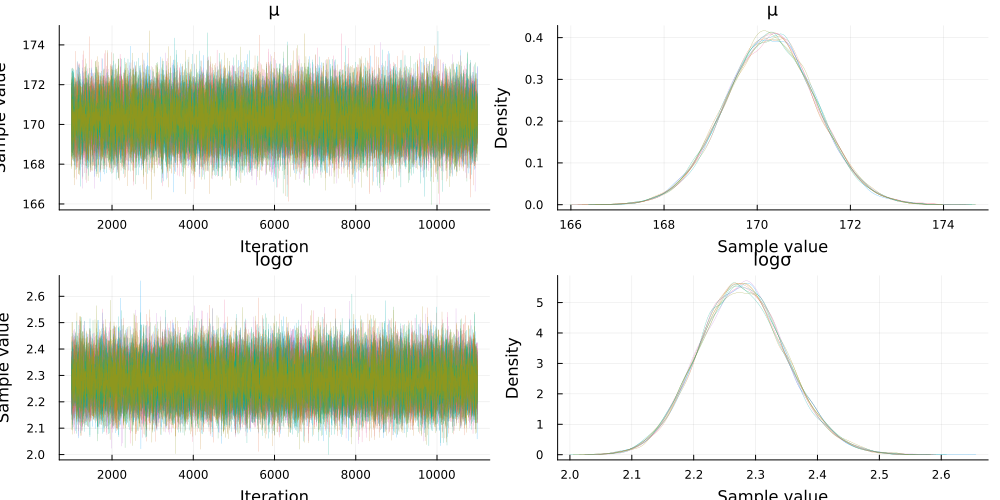

In [10]:
X = [
    143.7, 149.9, 151.7, 155.1, 155.4, 156.4, 157.1, 157.2, 157.7, 157.8,
    158.1, 158.3, 158.7, 159.2, 159.3, 159.8, 159.9, 160.0, 160.8, 161.1, 
    161.2, 161.9, 162.1, 162.2, 162.5, 163.1, 163.1, 164.2, 165.3, 165.3, 
    165.4, 165.5, 165.7, 166.3, 166.3, 166.7, 166.8, 166.9, 166.9, 167.0, 
    167.0, 167.1, 167.6, 167.8, 167.8, 167.9, 168.0, 168.8, 169.0, 169.1, 
    169.4, 169.6, 170.5, 170.6, 171.5, 172.2, 172.7, 173.0, 173.3, 173.7, 
    173.8, 173.9, 174.0, 175.0, 175.1, 175.7, 175.7, 175.8, 176.0, 176.2, 
    176.6, 177.1, 177.2, 177.3, 177.4, 177.5, 177.8, 177.8, 178.1, 179.2, 
    179.3, 179.6, 180.0, 180.1, 181.4, 181.6, 181.7, 182.3, 182.5, 183.3, 
    183.4, 183.4, 183.6, 183.7, 185.1, 185.8, 186.3, 186.7, 188.0, 195.5
]

N = 10^4
nchains=10
chain = sample(model_normal(X), NUTS(), MCMCThreads(), N, nchains)
println()

μ = sort(vec(chain[:μ]))

@show length(X) mean(X) std(X) log(std(X))
println()
@show confintmean(X) .|> r1
@show credint(μ) .|> r1
println()

display(chain)
println()

plot(chain; lw=0.2)

┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 9.765625e-5
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 21.44 seconds
Compute duration  = 196.17 seconds
parameters        = μ, logσ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse      ess_bulk      ess_tail      rhat   ess_per_sec 
      Symbol    Float64   Float64   Float64       Float64       Float64   Float64       Float64 

           μ   170.2862    0.9803    0.0010   983806.9927   726187.3348    1.0000     5015.0481
        logσ     2.2792    0.0714    0.0001   964274.5999   721137.9428    1.0000     4915.4799

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

     



n = length(X) = 100
x̄ = mean(X) = 170.287
s = std(X) = 9.719507147583112
prior_μ = Flat()
prior_logσ = Flat()
α = 0.05

pointest_ttest = 170.3
pointest_bayes = 170.4
ci_ttest = [168.4, 172.2]
ci_bayes = [168.4, 172.2]



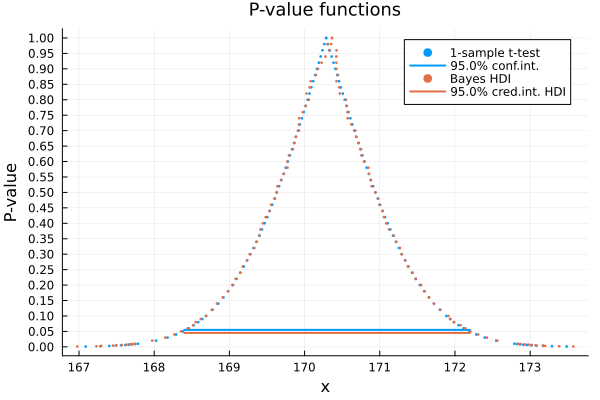

In [11]:
X = [
    143.7, 149.9, 151.7, 155.1, 155.4, 156.4, 157.1, 157.2, 157.7, 157.8,
    158.1, 158.3, 158.7, 159.2, 159.3, 159.8, 159.9, 160.0, 160.8, 161.1, 
    161.2, 161.9, 162.1, 162.2, 162.5, 163.1, 163.1, 164.2, 165.3, 165.3, 
    165.4, 165.5, 165.7, 166.3, 166.3, 166.7, 166.8, 166.9, 166.9, 167.0, 
    167.0, 167.1, 167.6, 167.8, 167.8, 167.9, 168.0, 168.8, 169.0, 169.1, 
    169.4, 169.6, 170.5, 170.6, 171.5, 172.2, 172.7, 173.0, 173.3, 173.7, 
    173.8, 173.9, 174.0, 175.0, 175.1, 175.7, 175.7, 175.8, 176.0, 176.2, 
    176.6, 177.1, 177.2, 177.3, 177.4, 177.5, 177.8, 177.8, 178.1, 179.2, 
    179.3, 179.6, 180.0, 180.1, 181.4, 181.6, 181.7, 182.3, 182.5, 183.3, 
    183.4, 183.4, 183.6, 183.7, 185.1, 185.8, 186.3, 186.7, 188.0, 195.5
]

plot_ci_mean(X)

┌ Info: Found initial step size
└   ϵ = 9.313225746154786e-11
┌ Info: Found initial step size
└   ϵ = 2.384185791015625e-8
┌ Info: Found initial step size
└   ϵ = 9.765625e-5
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 2.44140625e-5
┌ Info: Found initial step size
└   ϵ = 1.1920928955078126e-8
┌ Info: Found initial step size
└   ϵ = 1.220703125e-5
┌ Info: Found initial step size
└   ϵ = 3.7252902984619143e-10
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 22.37 seconds
Compute duration  = 219.8 seconds
parameters        = μ, logσ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse       ess_bulk      ess_tail      rhat   ess_per_sec 
      Symbol    Float64   Float64   Float64        Float64       Float64   Float64       Float64 

           μ   170.5700    0.9792    0.0010   1004526.8854   714890.3034    1.0000     4570.2484
        logσ     2.2794    0.0716    0.0001    985120.0127   727449.7887    1.0000     4481.9539

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

  



n = length(X) = 100
x̄ = mean(X) = 170.287
s = std(X) = 9.719507147583112
prior_μ = Normal{Float64}(μ=200.0, σ=10.0)
prior_logσ = Normal{Float64}(μ=0.0, σ=10.0)
α = 0.05

pointest_ttest = 170.3
pointest_bayes = 170.5
ci_ttest = [168.4, 172.2]
ci_bayes = [168.6, 172.5]



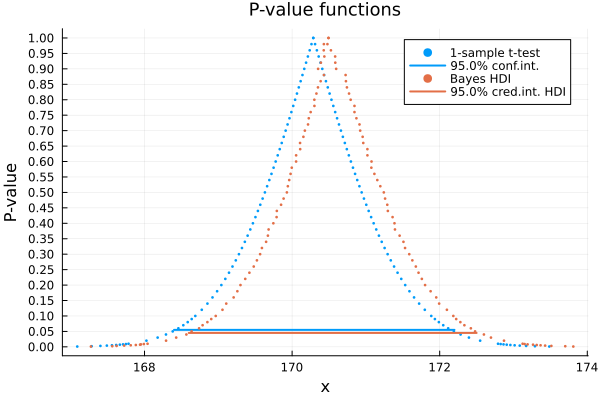

In [12]:
plot_ci_mean(X; prior_μ=Normal(200, 10), prior_logσ=Normal(0, 10))

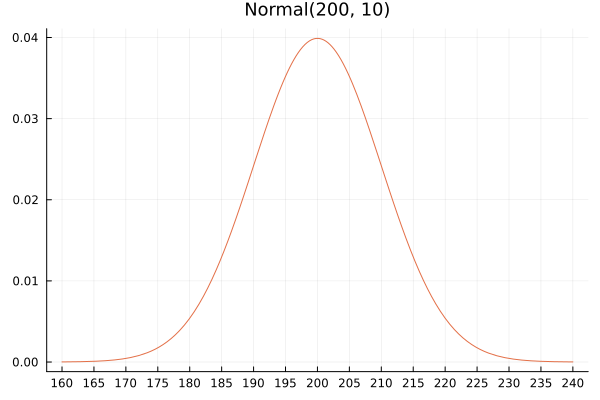

In [13]:
plot(Normal(200, 10), 160, 240; label="", title="Normal(200, 10)", xtick=160:5:240, c=2)

┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 1.4901161193847657e-9
┌ Info: Found initial step size
└   ϵ = 2.3283064365386964e-11
┌ Info: Found initial step size
└   ϵ = 0.000390625
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


Chains MCMC chain (100000×14×10 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 10
Samples per chain = 100000
Wall duration     = 20.81 seconds
Compute duration  = 201.46 seconds
parameters        = μ, logσ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse      ess_bulk      ess_tail      rhat   ess_per_sec 
      Symbol    Float64   Float64   Float64       Float64       Float64   Float64       Float64 

           μ   171.4016    0.9820    0.0010   928612.3339   700044.0264    1.0000     4609.4816
        logσ     2.2855    0.0724    0.0001   924299.6120   721565.1918    1.0000     4588.0739

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

     



n = length(X) = 100
x̄ = mean(X) = 170.287
s = std(X) = 9.719507147583112
prior_μ = Normal{Float64}(μ=200.0, σ=5.0)
prior_logσ = Normal{Float64}(μ=0.0, σ=10.0)
α = 0.05

pointest_ttest = 170.3
pointest_bayes = 171.4
ci_ttest = [168.4, 172.2]
ci_bayes = [169.5, 173.3]



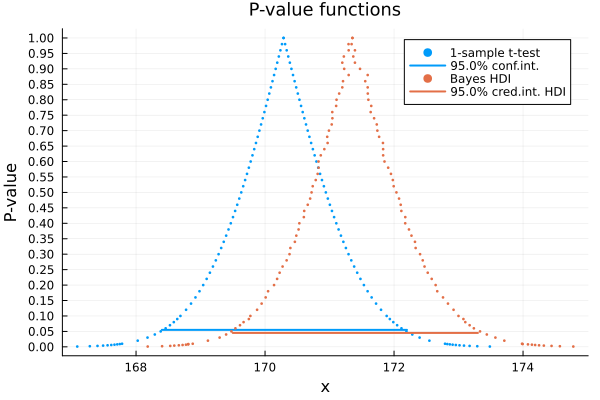

In [14]:
plot_ci_mean(X; prior_μ=Normal(200, 5), prior_logσ=Normal(0, 10))

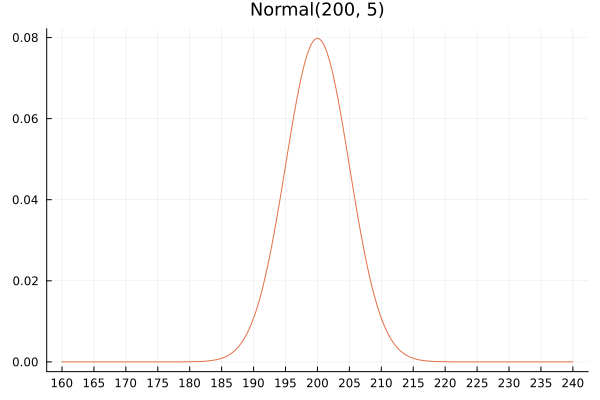

In [15]:
plot(Normal(200, 5), 160, 240; label="", title="Normal(200, 5)", xtick=160:5:240, c=2)